# This notebook requires DASH Code to run.

It requires `multilayer_convnet.py`: https://github.com/daniel-muthukrishna/astrodash/blob/master/astrodash/multilayer_convnet.py

Additionally, this notebook requires the retrained DASH models which we do not host.

In [1]:
import sys
import os
from os.path import join, isdir
import glob

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot as plt
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ModuleNotFoundError:
    import tensorflow as tf

from multilayer_convnet import convnet_variables
from icecream import ic

figdir = "./"

2025-07-11 00:17:19.599558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-11 00:17:19.970406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-11 00:17:20.151316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 00:17:21.159122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-11 00:18:36.255971: W tensorflow/compiler/tf2

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
"""Initialize useful dictionaries for SN data."""
SNtypes_str = np.array(
    [
        "Ia-norm",
        "Ia-91T",
        "Ia-91bg",
        "Ia-csm",
        "Iax",
        "Ia-pec",
        "Ib-norm",
        "Ibn",
        "IIb",
        "Ib-pec",
        "Ic-norm",
        "Ic-broad",
        "Ic-pec",
        "IIP",
        "IIL",
        "IIn",
        "II-pec",
    ]
)
SNtypes_int = np.arange(SNtypes_str.size)
SNtypes_str_to_int = {
    SNtype_str: SNtype_int for SNtype_str, SNtype_int in zip(SNtypes_str, SNtypes_int)
}
SNtypes_int_to_str = {j: i for i, j in SNtypes_str_to_int.items()}


SNbroadtypes_str = np.array(["Ia", "Ib", "Ic", "II"])
SNbroadtypes_int = np.arange(SNbroadtypes_str.size)
SNbroadtypes_str_to_int = {
    SNbroadtype_str: SNbroadtype_int
    for SNbroadtype_str, SNbroadtype_int in zip(SNbroadtypes_str, SNbroadtypes_int)
}
SNbroadtypes_int_to_str = {j: i for i, j in SNbroadtypes_str_to_int.items()}


"""Common corrections for SN names"""
SNtypes_str_to_int["Ia-02cx"] = SNtypes_str_to_int["Iax"]
SNtypes_str_to_int["Ia-99aa"] = SNtypes_str_to_int["Ia-91T"]
SNtypes_str_to_int["Ib"] = SNtypes_str_to_int["Ib-norm"]
SNtypes_str_to_int["Ic"] = SNtypes_str_to_int["Ic-norm"]

EXCLUDED_SNTYPES = ["Ia-csm", "Ia-pec", "Ib-pec", "Ic-pec", "IIL", "IIn", "II-pec"]
EXCLUDED_SNTYPES_int = [SNtypes_str_to_int[SNtype_str] for SNtype_str in EXCLUDED_SNTYPES]

In [71]:
def get_DASH_results(R, LIBRARY_PATH, MODELS_PATH):
    R_dir = os.path.join(MODELS_PATH, str(R))
    snidTemplateLocation = os.path.join(LIBRARY_PATH, str(R), "lnw_files")

    BACKUP_DIR = os.path.join(R_dir, "backup")
    training_set_dir = os.path.join(R_dir,  "training_set")
    history = pd.read_csv(os.path.join(R_dir, "history.csv"))
    MODEL_DIR = BACKUP_DIR

    trainImages = np.load(
        os.path.join(training_set_dir, "trainImages.npy"),
        mmap_mode="r")
    trainLabels = np.load(
        os.path.join(training_set_dir, "trainLabels.npy"),
        mmap_mode="r")
    trainTypeNames = np.load(
        os.path.join(training_set_dir, "trainTypeNames.npy"),
        mmap_mode="r")

    testImages = np.load(
        os.path.join(training_set_dir, "testImages.npy"),
        mmap_mode="r")
    testLabels = np.load(
        os.path.join(training_set_dir, "testLabels.npy"),
        mmap_mode="r")
    testTypeNames = np.load(
        os.path.join(training_set_dir, "testTypeNames.npy"),
        mmap_mode="r")

    typeNamesList = np.load(
        os.path.join(training_set_dir, "typeNamesList.npy"),
        mmap_mode="r")

    ic(trainImages.shape)
    ic(trainLabels.shape)
    ic(trainTypeNames.shape)
    ic(testImages.shape)
    ic(testLabels.shape)
    ic(testTypeNames.shape)
    ic(typeNamesList.shape)

    classes_per_subtype = 18
    num_classes = 306
    SubTypeIndices = np.arange(0, num_classes + 1, classes_per_subtype)
    SubTypeIndices, SubTypeIndices.shape

    Ytrn = np.digitize(trainLabels, SubTypeIndices) - 1
    Ytst = np.digitize(testLabels, SubTypeIndices) - 1
    used_subtypes_trn_int = np.unique(Ytrn)
    used_subtypes_tst_int = np.unique(Ytst)
    used_subtypes_trn_str = [SNtypes_int_to_str[SNtype] for SNtype in used_subtypes_trn_int]
    used_subtypes_tst_str = [SNtypes_int_to_str[SNtype] for SNtype in used_subtypes_tst_int]

    print(f"{R}: {used_subtypes_trn_int.size}, {used_subtypes_tst_int.size}")

    tf.reset_default_graph()
    nw = len(testImages[0])
    nBins = len(typeNamesList)
    imWidthReduc = 8
    imWidth = 32  # Image size and width
    x, y_, keep_prob, y_conv, W, b = convnet_variables(imWidth, imWidthReduc, nw, nBins)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        index_files = glob.glob(os.path.join(MODEL_DIR, "*.index"))
        latest_ckpt = max(index_files, key=os.path.getctime)
        saver = tf.train.Saver()
        saver.restore(sess, latest_ckpt.split(".index")[0])

        Ptst = y_conv.eval(feed_dict={x: testImages, keep_prob: 1.0})
        Ptrn = y_conv.eval(feed_dict={x: trainImages, keep_prob: 1.0})

    Ptst = np.argmax(Ptst, axis=1)
    Ptrn = np.argmax(Ptrn, axis=1)

    Ytst_SubType = np.digitize(testLabels, SubTypeIndices) - 1
    Ptst_SubType = np.digitize(Ptst, SubTypeIndices) - 1

    Ytrn_SubType = np.digitize(trainLabels, SubTypeIndices) - 1
    Ptrn_SubType = np.digitize(Ptrn, SubTypeIndices) - 1

    acc_tst = accuracy_score(Ytst_SubType, Ptst_SubType)
    acc_trn = accuracy_score(Ytrn_SubType, Ptrn_SubType)
    print(f"DASH Accuracy (Testing Set): {acc_tst*100:.4f}%")
    print(f"DASH Accuracy (Training Set): {acc_trn*100:.4f}%")

    print(np.unique(Ytst_SubType))
    f1_tst = f1_score(Ytst_SubType, Ptst_SubType, labels=np.unique(Ytst_SubType), average="macro")
    f1_trn = f1_score(Ytrn_SubType, Ptrn_SubType, labels=np.unique(Ytrn_SubType), average="macro")
    print(f"DASH Macro F1-Score (Testing Set): {f1_tst*100:.4f}%")
    print(f"DASH Macro F1-Score (Training Set): {f1_trn*100:.4f}%")

    CMtst_0 = sklearn.metrics.confusion_matrix(Ytst_SubType, Ptst_SubType, normalize=None)
    CMtst_R = sklearn.metrics.confusion_matrix(Ytst_SubType, Ptst_SubType, normalize="true")
    CMtst_C = sklearn.metrics.confusion_matrix(Ytst_SubType, Ptst_SubType, normalize="pred")

    classes = [SNtypes_int_to_str[sntype] for sntype in np.unique(Ytst_SubType)]
    selected_classes = [
        'Ia-norm',
        'Ia-91T',
        'Ia-91bg',
        'Iax',
        'Ib-norm',
         'Ibn',
        'IIb',
        'Ic-norm',
        'Ic-broad',
        'IIP',
    ]

    ind = np.array([True if c in selected_classes else False for c in classes])
    classes = np.array(classes)[ind]

    CMtst_0 = CMtst_0[ind].T[ind].T
    CMtst_R = CMtst_R[ind].T[ind].T
    CMtst_C = CMtst_C[ind].T[ind].T

    # CMtrn = sklearn.metrics.confusion_matrix(Ytrn_SubType, Ptrn_SubType)
    # classes = [SNtypes_int_to_str[sntype] for sntype in np.unique(Ytrn_SubType)]
    return CMtst_0, CMtst_R, CMtst_C, classes

In [72]:
lustre = "/lustre/lrspec/users/2649"
d1 = join(lustre, "DASH_16types_originalTTS_allowOverfitting_noEarlystopping_500000batches")
d2 = join(lustre, "DASH_16types_originalTTS_disallowOverfitting_yesEarlystopping_100epochs")
d3 = join(lustre, "DASH_16types_newTTS_disallowOverfitting_yesEarlystopping_100epochs")

cm1_0, cm1_R, cm1_C, classes1 = get_DASH_results(100, join(d1, "lnw_files_at_R"), join(d1, "models"))
cm2_0, cm2_R, cm2_C, classes2 = get_DASH_results(100, join(d2, "lnw_files_at_R"), join(d2, "models"))
cm3_0, cm3_R, cm3_C, classes3 = get_DASH_results(100, join(d3, "lnw_files_at_R"), join(d3, "models"))

ic| trainImages.shape: (136800, 1024)
ic| trainLabels.shape: (136800,)
ic| trainTypeNames.shape: (136800,)
ic| testImages.shape: (135520, 1024)
ic| testLabels.shape: (135520,)
ic| testTypeNames.shape: (135520,)
ic| typeNamesList.shape: (306,)


100: 16, 16
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_16types_originalTTS_allowOverfitting_noEarlystopping_500000batches/models/100/backup/model-499000
DASH Accuracy (Testing Set): 89.1972%
DASH Accuracy (Training Set): 100.0000%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
DASH Macro F1-Score (Testing Set): 78.8413%
DASH Macro F1-Score (Training Set): 100.0000%


ic| trainImages.shape: (136800, 1024)
ic| trainLabels.shape: (136800,)
ic| trainTypeNames.shape: (136800,)
ic| testImages.shape: (135520, 1024)
ic| testLabels.shape: (135520,)
ic| testTypeNames.shape: (135520,)
ic| typeNamesList.shape: (306,)


100: 16, 16
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_16types_originalTTS_disallowOverfitting_yesEarlystopping_100epochs/models/100/backup/model-1950
DASH Accuracy (Testing Set): 81.9953%
DASH Accuracy (Training Set): 90.4678%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
DASH Macro F1-Score (Testing Set): 76.8905%
DASH Macro F1-Score (Training Set): 95.3014%


ic| trainImages.shape: (116640, 1024)
ic| trainLabels.shape: (116640,)
ic| trainTypeNames.shape: (116640,)
ic| testImages.shape: (143920, 1024)
ic| testLabels.shape: (143920,)
ic| testTypeNames.shape: (143920,)
ic| typeNamesList.shape: (306,)


100: 16, 16
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_16types_newTTS_disallowOverfitting_yesEarlystopping_100epochs/models/100/backup/model-550
DASH Accuracy (Testing Set): 59.0328%
DASH Accuracy (Training Set): 68.7929%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
DASH Macro F1-Score (Testing Set): 39.6983%
DASH Macro F1-Score (Training Set): 75.4157%


In [6]:
cm1_0.shape, cm1_R.shape, cm1_C.shape

((10, 10), (10, 10), (10, 10))

In [7]:
cm2_0.shape, cm2_R.shape, cm2_C.shape

((10, 10), (10, 10), (10, 10))

In [8]:
cm3_0.shape, cm3_R.shape, cm3_C.shape

((10, 10), (10, 10), (10, 10))

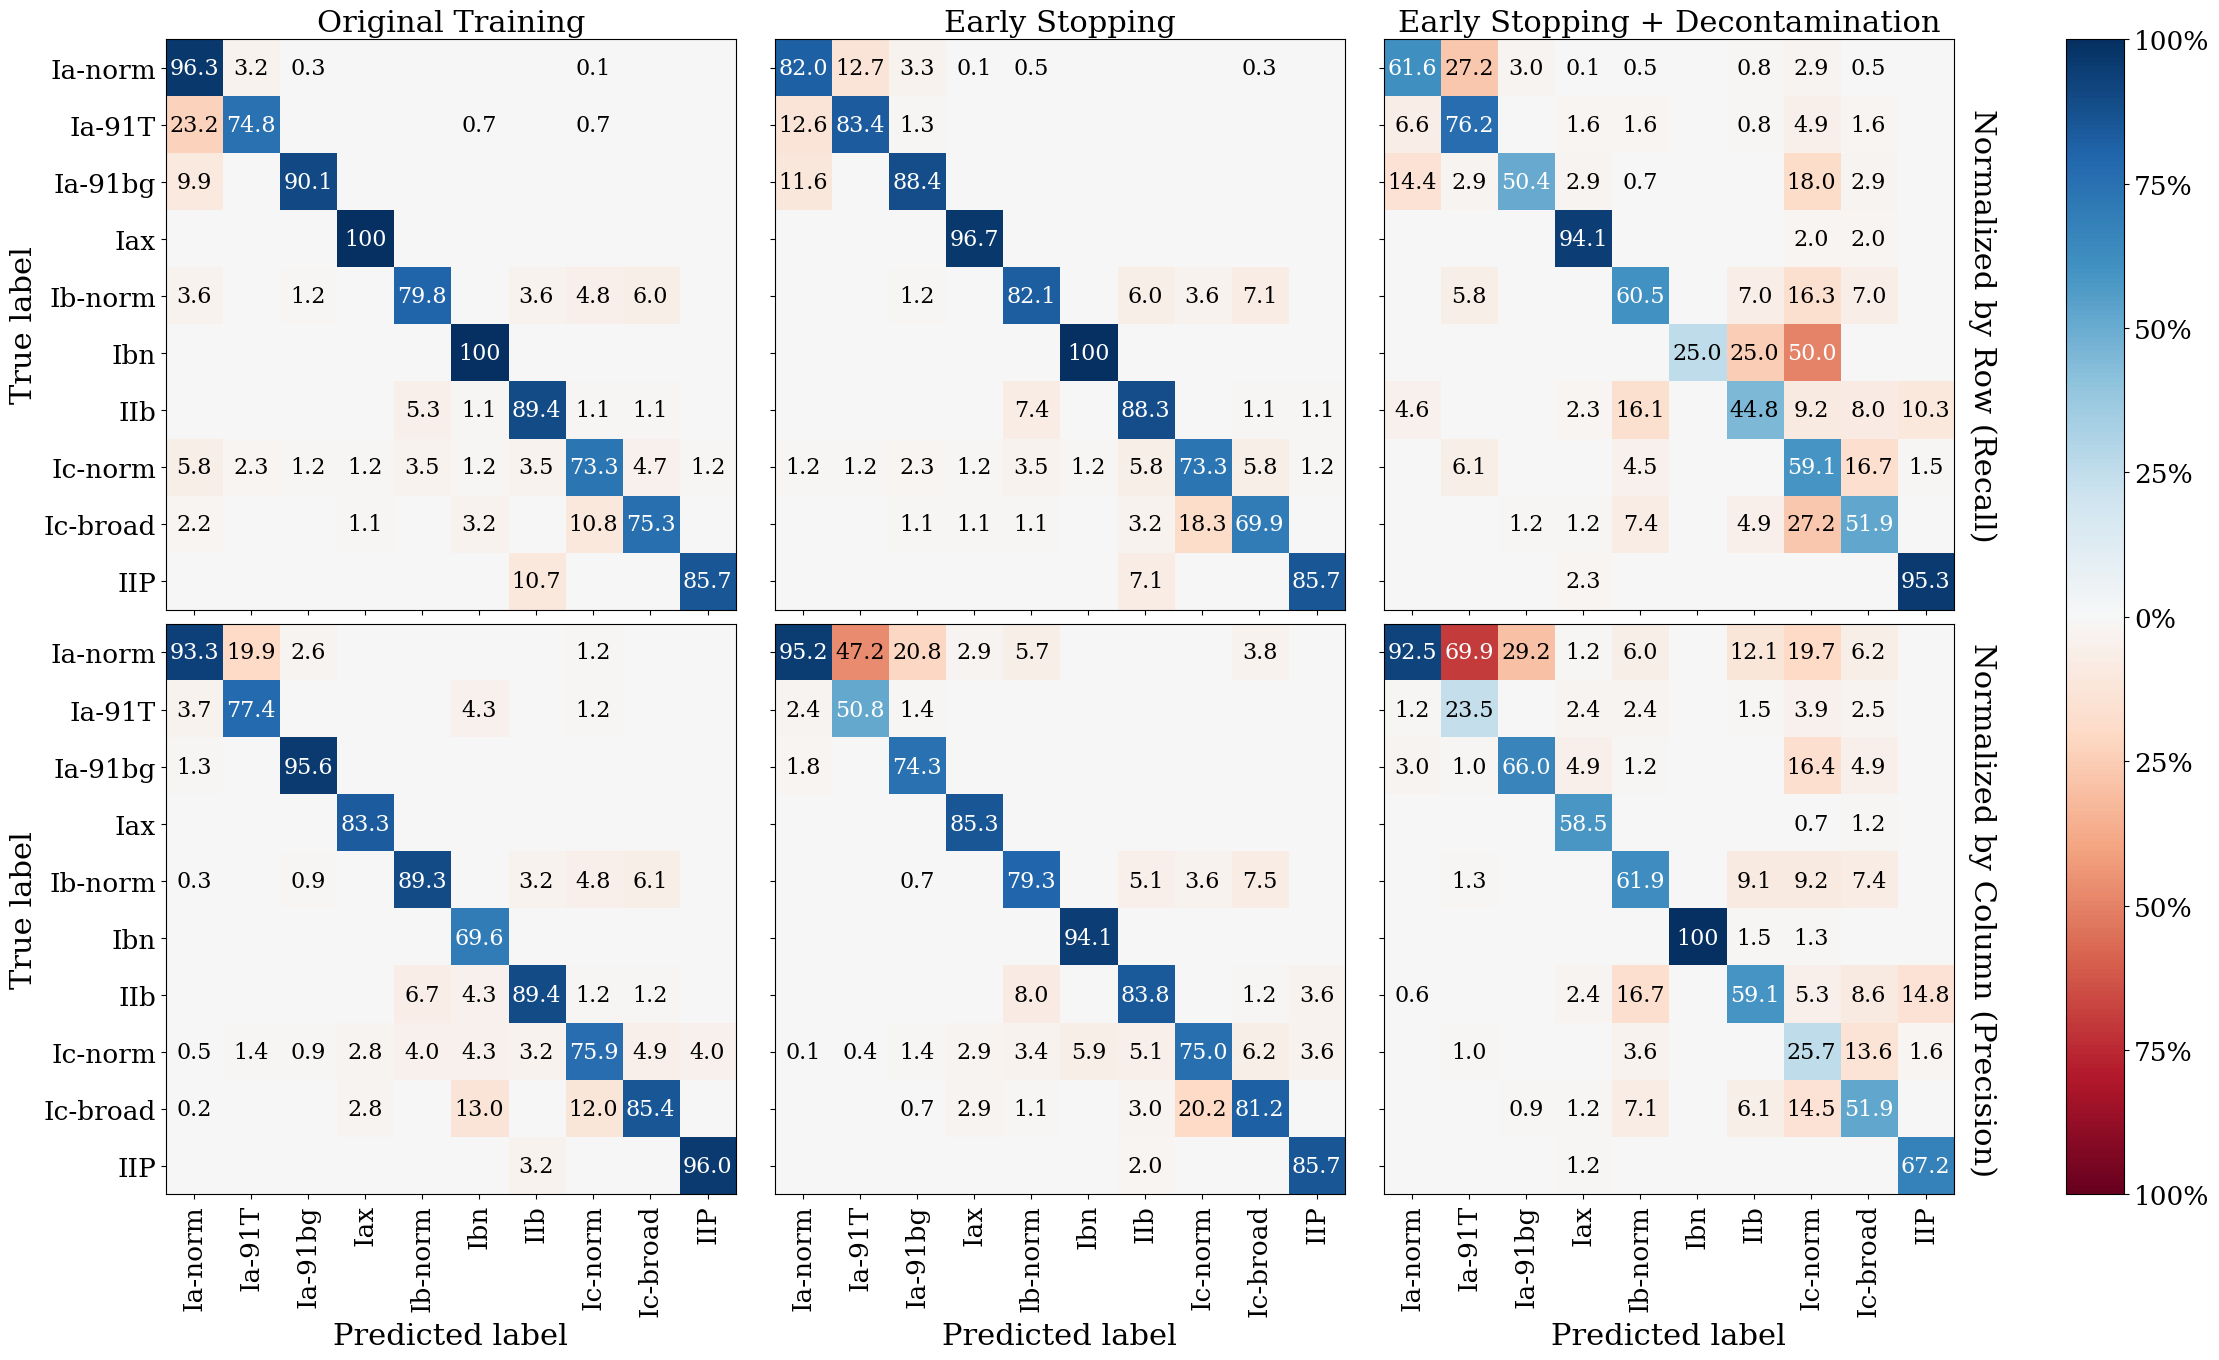

In [73]:
def plot_DASH_6CM(
    cm1_R, cm2_R, cm3_R,
    cm1_C, cm2_C, cm3_C,
    classes1, classes2, classes3,
    figsize=(20, 10),
):
    textargs = {"fontname": "Serif"}
    fs_ticks = 19
    fs_cmtext = 16
    fs_ax_labels = 22

    off_diag = ~np.eye(cm1_R.shape[0], dtype=bool)

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=figsize)
    fig.subplots_adjust(wspace=0.05, hspace=0.025)
    cms_R = [cm1_R.copy(), cm2_R.copy(), cm3_R.copy()]
    cms_C = [cm1_C.copy(), cm2_C.copy(), cm3_C.copy()]
    classes_arr = [classes1, classes2, classes3]

    ims_R = []
    ims_C = []
    for k, (cm_R, cm_C, classes) in enumerate(zip(cms_R, cms_C, classes_arr)):
        cms_R[k][off_diag] *= -1
        cms_C[k][off_diag] *= -1

        im_R = axes[0, k].imshow(cm_R, interpolation=None, cmap="RdBu", vmin=-1, vmax=1)
        im_C = axes[1, k].imshow(cm_C, interpolation=None, cmap="RdBu", vmin=-1, vmax=1)

        ims_R.append(im_R)
        ims_C.append(im_C)

        tick_marks = np.arange(len(classes))
        axes[0, k].set_xticks(tick_marks, classes, rotation=90, **textargs, fontsize=fs_ticks)
        axes[0, k].set_yticks(tick_marks, classes, **textargs, fontsize=fs_ticks)
        axes[1, k].set_xticks(tick_marks, classes, rotation=90, **textargs, fontsize=fs_ticks)
        axes[1, k].set_yticks(tick_marks, classes, **textargs, fontsize=fs_ticks)

        for i in range(cm_R.shape[0]):
            for j in range(cm_R.shape[1]):
                val = np.abs(cm_R[i, j])
                if val == 0:
                    text = ""
                elif val == 1:
                    text = "100"
                else:
                    text = f"{val*100:.1f}"
                color = "w" if val >= 0.50 else "k"
                axes[0, k].text(
                    j, i, text,
                    ha="center", va="center",
                    c=color, **textargs, fontsize=fs_cmtext)

                val = np.abs(cm_C[i, j])
                if val == 0:
                    text = ""
                elif val == 1:
                    text = "100"
                else:
                    text = f"{val*100:.1f}"
                color = "w" if val >= 0.50 else "k"
                axes[1, k].text(
                    j, i, text,
                    ha="center", va="center",
                    c=color, **textargs, fontsize=fs_cmtext)

        if k == 0:
            axes[0, k].set_ylabel("True label", fontsize=fs_ax_labels, **textargs)
            axes[1, k].set_ylabel("True label", fontsize=fs_ax_labels, **textargs)
        axes[1, k].set_xlabel("Predicted label", fontsize=fs_ax_labels, **textargs)



    axes[0, 0].set_title("Original Training", fontsize=fs_ax_labels, **textargs)
    axes[0, 1].set_title("Early Stopping", fontsize=fs_ax_labels, **textargs)
    axes[0, 2].set_title("Early Stopping + Decontamination", fontsize=fs_ax_labels, **textargs)


    axes[0, 2].text(
        10, 4.5,
        "Normalized by Row (Recall)",
        rotation=270,
        ha="center", va="center",
        c="k",
        **textargs,
        fontsize=fs_ax_labels,
    )

    axes[1, 2].text(
        10, 4.5,
        "Normalized by Column (Precision)",
        rotation=270,
        ha="center", va="center",
        c="k",
        **textargs,
        fontsize=fs_ax_labels,
    )

    cbticks = np.linspace(-1, 1, num=9)
    cbticklabels = ["100%", "75%", "50%", "25%", "0%", "25%", "50%", "75%", "100%"]
    cb = plt.colorbar(
        im_R,
        ax=axes,
        orientation="vertical",
        location="right",
        # anchor=(-0.5, 0),
        # aspect=50,
        # shrink=0.95,
    )
    cb.set_ticks(cbticks, labels=cbticklabels, fontsize=19, **textargs)


    return fig


fig = plot_DASH_6CM(
    cm1_R, cm2_R, cm3_R,
    cm1_C, cm2_C, cm3_C,
    classes1, classes2, classes3,
    figsize=(29, 15))
# fig.tight_layout()
fig.savefig(join(figdir, "DASH_6CM.pdf"))
fig.show()